In [1]:
# 1: LOAD LIBS, UTILITIES, DATASETS
# 2A: MLP DEFINE AUTO-TUNER 
# 2B: MLP OPTION 1: CREATE NEW AUTO-TUNER RESULTS (TAKES > 1 HOUR)
# 2C: MLP OPTION 2: LOAD EXISTING AUTO-TUNER RESULTS 
# 2D: MLP APPLY 3 BEST MLP MODELS TO CIFAR10 DATA (overwrites existing results)
# 2E: MLP COMPARE RESULTS WITH CIFAR10 DATA
# 3A: CNN DEFINE AUTO-TUNER 
# 3B: CNN OPTION 1: CREATE NEW AUTO-TUNER RESULTS (TAKES > 1 HOUR)
# 3C: CNN OPTION 2: LOAD EXISTING AUTO-TUNER RESULTS 
# 3D: CNN APPLY 3 BEST MLP MODELS TO CIFAR10 DATA (overwrites existing results)
# 3E: CNN COMPARE RESULTS WITH CIFAR10 DATA

# set to False if you want to run new data, True if existing data is available
load_existing = True

2023-11-09 14:22:11.697745: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 14:22:11.724205: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 14:22:11.724228: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 14:22:11.724251: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 14:22:11.729781: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend


2023-11-09 14:22:13.167071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 14:22:13.211038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 14:22:13.211159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[9 0 0 ... 3 0 5]


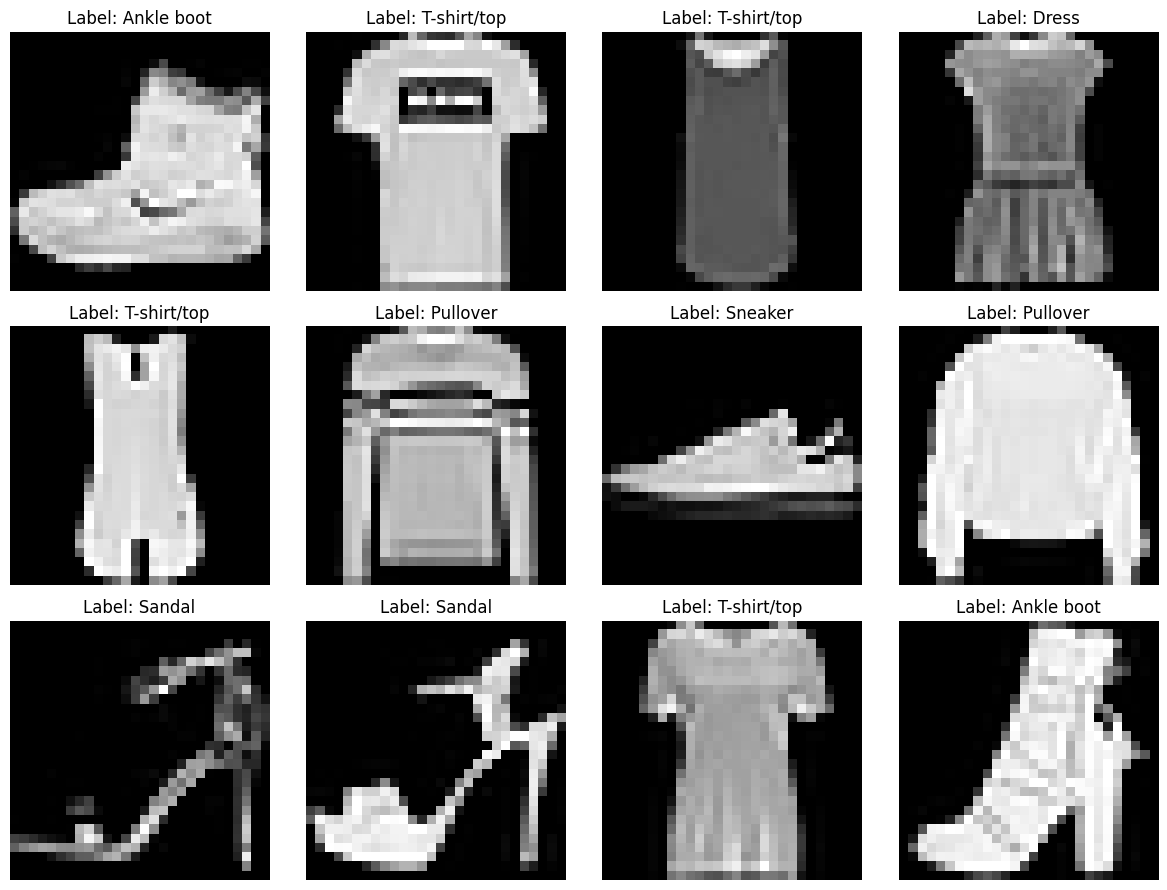

[6 9 9 ... 9 1 1]


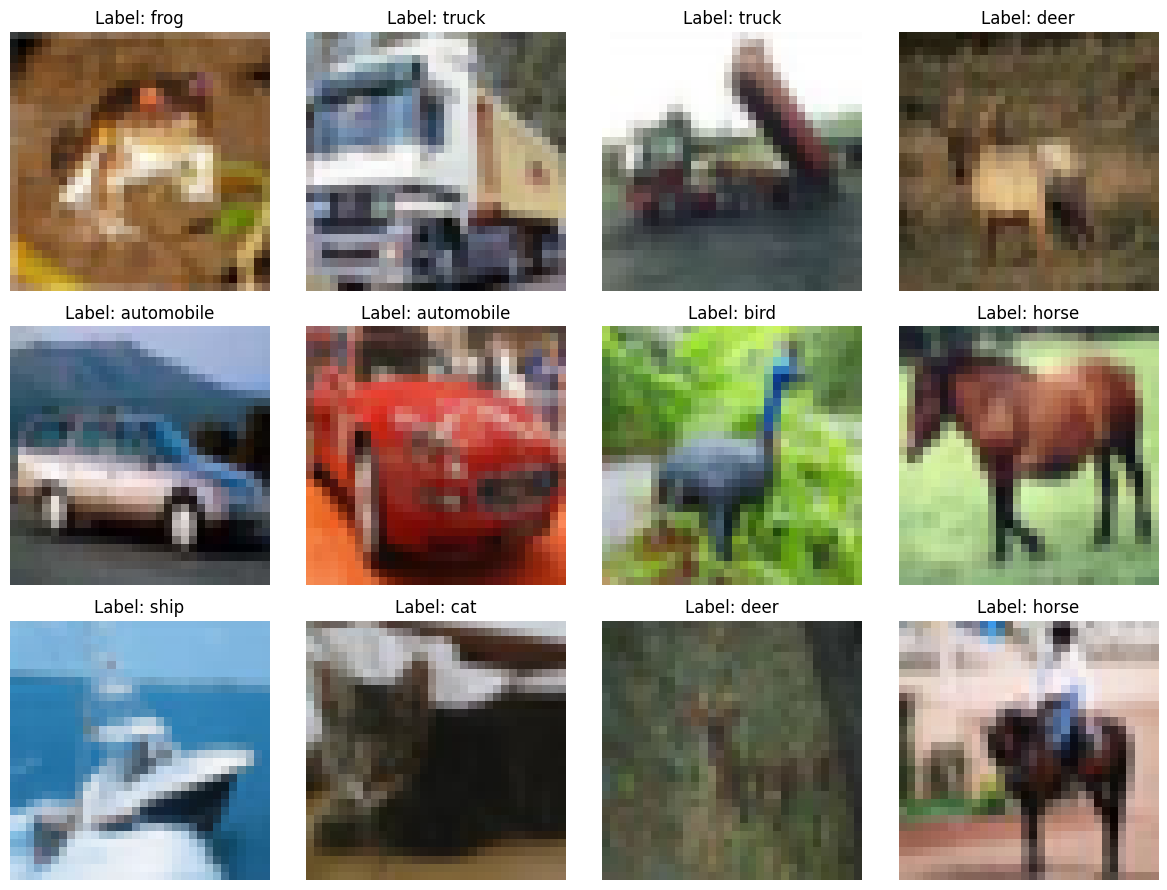

In [2]:
# LOAD LIBS, UTILITIES, DATASETS

# ! pip install keras_tuner
import numpy as np
import os
import datetime
import keras
import tensorflow as tf
from keras.datasets import fashion_mnist, cifar10
from keras import layers
import keras_tuner
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# no GPU available 
tf.config.set_visible_devices([], 'GPU')
optimizers = {
    "sgd": keras.optimizers.SGD,
    "adam": keras.optimizers.Adam,
}

# set up callbacks
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/' + current_time
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss',factor=0.6,patience=2,min_lr=1.0e-9)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks=[early_stopping, tensorboard, lr_schedule]

# LOAD & SHOW FASHION MNIST DATA
fm_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

num_classes = len(fm_class_names)
(fm_x_train,fm_y_train), (fm_x_test,fm_y_test) = fashion_mnist.load_data()
fm_x_train, fm_x_test = fm_x_train/255.0, fm_x_test/255.0
fm_y_train_cat = keras.utils.to_categorical(fm_y_train, num_classes)
fm_y_test_cat = keras.utils.to_categorical(fm_y_test, num_classes)
print(fm_y_train)

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Plot 3x4 images from x_train
for ind, ax in enumerate(axes.ravel()):
    ax.imshow(fm_x_train[ind], cmap='gray')
    ax.set_title(f"Label: {fm_class_names[fm_y_train[ind]]}")
    ax.axis('off')

# Display the subplots
plt.tight_layout()
plt.show()

# LOAD & SHOW CFAR10 DATA
cf_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(cf_x_train,cf_y_train), (cf_x_test,cf_y_test) = cifar10.load_data()
cf_x_train, cf_x_test = cf_x_train/255.0, cf_x_test/255.0
cf_y_train, cf_y_test = cf_y_train.ravel(), cf_y_test.ravel()
cf_y_train_cat = keras.utils.to_categorical(cf_y_train, num_classes)
cf_y_test_cat = keras.utils.to_categorical(cf_y_test, num_classes)
print(cf_y_train)

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Plot 3x4 images from x_train
for ind, ax in enumerate(axes.ravel()):
    ax.imshow(cf_x_train[ind])
    ax.set_title(f"Label: {cf_class_names[cf_y_train[ind]]}")
    ax.axis('off')

# Display the subplots
plt.tight_layout()
plt.show()

In [3]:
# 2A: MLP DEFINE AUTO-TUNER 

def build_model_mlp(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    activation=hp.Choice("activation", ["relu", "tanh"])
    dropout = hp.Boolean("dropout")
    # Tune the number of layers.
    for i in range(3):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=num_classes*2, max_value=num_classes*50, step=num_classes*2),
                activation=activation,
            )
        )
        if dropout:
            model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(10, activation="softmax"))
    optimizer_choice = hp.Choice("optimizer", ["sgd","adam"])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")

    optimizer = optimizers[optimizer_choice](learning_rate = learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model



In [4]:
# 2B: MLP OPTION 1: CREATE NEW AUTO-TUNER RESULTS (TAKES > 1 HOUR)
if load_existing == False:
    dir_name, project_name = "mlp_dir","mlp"

    tuner_mlp = keras_tuner.BayesianOptimization(
        hypermodel=build_model_mlp,
        objective="val_accuracy",
        max_trials=40,
        num_initial_points=10,  # Number of initial random trials
        overwrite=True,
        directory=dir_name,
        project_name=project_name,
    )
    tuner_mlp.search_space_summary()

    # Setting up TensorBoard callback

    tuner_mlp.search(fm_x_train, fm_y_train_cat, epochs=30, validation_split=0.1, callbacks=callbacks)

    best_models = tuner_mlp.get_best_models(num_models=10)
    best_hps = tuner_mlp.get_best_hyperparameters(num_trials=10)
    tuner_mlp.results_summary(num_trials=10)


In [5]:
# 2C: MLP OPTION 2: LOAD EXISTING AUTO-TUNER RESULTS 
if load_existing == True:
    dir_name, project_name = f"mlp","mlp"

    tuner_mlp = keras_tuner.BayesianOptimization(
        hypermodel=build_model_mlp,
        objective="val_accuracy",
        max_trials=40,
        num_initial_points=10,  # Number of initial random trials
        overwrite=False,
        directory=dir_name,
        project_name=project_name
    )

    print(tuner_mlp.results_summary(num_trials=3))

Reloading Tuner from mlp/mlp/tuner0.json
Results summary
Results in mlp/mlp
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 37 summary
Hyperparameters:
activation: tanh
dropout: False
units_0: 340
units_1: 200
units_2: 100
optimizer: sgd
lr: 0.014632537748798285
Score: 0.8953333497047424

Trial 05 summary
Hyperparameters:
activation: relu
dropout: False
units_0: 220
units_1: 20
units_2: 500
optimizer: sgd
lr: 0.013230002827791071
Score: 0.893833339214325

Trial 29 summary
Hyperparameters:
activation: relu
dropout: False
units_0: 500
units_1: 460
units_2: 500
optimizer: sgd
lr: 0.1
Score: 0.8930000066757202
None


In [6]:
# 2D: APPLY 3 BEST MLP MODELS TO CIFAR10 DATA

if load_existing == False:

    filename = "cifar10_mlp_best_hp"
    if not os.path.exists(filename):
        os.makedirs(filename)
        best_hp_sets = tuner_mlp.get_best_hyperparameters(num_trials=3)

    for ind,best_hps in enumerate(best_hp_sets):
        model_best_cf = build_model_mlp(best_hps)
        model_best_cf.build(cf_x_train.shape)
        print(model_best_cf.summary())
        history = model_best_cf.fit(cf_x_train, cf_y_train_cat, epochs=30, validation_split=0.1, callbacks=callbacks)
        np.save(f'{filename}/{filename}_{ind+1}.npy', history.history)  # Save the history as a NumPy array


In [7]:
# 2E: COMPARE RESULTS WITH CIFAR10 DATA
if load_existing == True:

  for ind,best_trial in enumerate(tuner_mlp.oracle.get_best_trials(3)):
    cf_hist = np.load(f"cifar10_mlp_best_hp/cifar10_mlp_best_hp_{ind+1}.npy",allow_pickle=True).item()
    best_cf_val_acc_ind = np.argmax(cf_hist["val_accuracy"])
    print(f"Best trial {ind+1}")
    print(f'fashion_mnist accuracy: {best_trial.metrics.get_best_value("accuracy"):.3f}, fashion_mnist val_accuracy:{best_trial.metrics.get_best_value("val_accuracy"):.3f}')
    print(f'cifar10 accuracy: {cf_hist["accuracy"][best_cf_val_acc_ind]:.3f}, cifar10 val_accuracy:{cf_hist["val_accuracy"][best_cf_val_acc_ind]:.3f}\n')

Best trial 1
fashion_mnist accuracy: 0.923, fashion_mnist val_accuracy:0.895
cifar10 accuracy: 0.557, cifar10 val_accuracy:0.521

Best trial 2
fashion_mnist accuracy: 0.922, fashion_mnist val_accuracy:0.894
cifar10 accuracy: 0.527, cifar10 val_accuracy:0.485

Best trial 3
fashion_mnist accuracy: 0.913, fashion_mnist val_accuracy:0.893
cifar10 accuracy: 0.531, cifar10 val_accuracy:0.439



In [8]:
#3A: DEFINE AUTO-TUNER CNN 

def build_model_cnn(hp,input_shape=(28,28,1)):
    model = keras.Sequential()
    activation=hp.Choice("activation", ["relu", "tanh"])
    inp_filters = hp.Int("input_conv_filter", min_value=32, max_value = 128, step=32)
    model.add(layers.Conv2D(
        filters=inp_filters,
        kernel_size=hp.Choice('input_conv_kernel', values = [5,7]),
        activation=activation,
        input_shape=input_shape)
    )
    model.add(layers.MaxPooling2D(2))
    filters = hp.Int("conv_filters", min_value=inp_filters, max_value=256, step=32)
    for i in range(hp.Int("conv_layers",0,2)):
      model.add(
          layers.Conv2D(
              # Tune number of units separately.
              filters=filters,
              kernel_size=3,
              activation=activation,
          )
      )
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Flatten())
    dropout = hp.Boolean("dropout")
    # Tune the number of layers.
    unit_min, unit_max= 128,256
    for i in range(hp.Int("num_layers",1,2)):
        unit_count = hp.Int(f"units_{i}", min_value=unit_min, max_value=unit_max, step=32)
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=unit_count,
                activation=activation,
            )
        )
        if dropout:
            model.add(layers.Dropout(rate=0.25))
        unit_min, unit_max = int(unit_min/2), unit_count

    model.add(layers.Dense(10, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-2, max_value=1e-1, sampling="log")
    optimizer = optimizers[hp.Choice("optimizer",['sgd','adam'])]()
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [10]:
#3B: OPTION 1: CREATE NEW AUTO-TUNER RESULTS (TAKES > 1 HOUR)
if load_existing == False:

    dir_name, project_name = "cnn_dir","cnn"

    tuner_cnn = keras_tuner.BayesianOptimization(
        hypermodel=build_model_cnn,
        objective="val_accuracy",
        max_trials=20,
        num_initial_points=10,  # Number of initial random trials
        overwrite=True,
        directory=dir_name,
        project_name=project_name,
    )
    tuner_cnn.search_space_summary()
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)
    lr_schedule = ReduceLROnPlateau(monitor='val_loss',factor=0.6,patience=2,min_lr=1.0e-9)
    tuner_cnn.search(fm_x_train, fm_y_train_cat, epochs=20, validation_split=0.1,callbacks=callbacks)

In [11]:
#3C: OPTION 2: LOAD EXISTING AUTO-TUNER RESULTS 
if load_existing == True:

    dir_name, project_name = f"cnn","cnn"
    # loaded_tuner = keras_tuner. from_directory('content/test')
    tuner_cnn = keras_tuner.BayesianOptimization(
        hypermodel=build_model_cnn,
        objective="val_accuracy",
        max_trials=40,
        num_initial_points=10,  # Number of initial random trials
        overwrite=False,
        directory=dir_name,
        project_name=project_name
    )
    print(tuner_cnn.results_summary(num_trials=3))

Reloading Tuner from cnn/cnn/tuner0.json
Results summary
Results in cnn/cnn
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
activation: relu
input_conv_filter: 128
input_conv_kernel: 5
conv_filters: 32
conv_layers: 0
dropout: True
num_layers: 1
units_0: 192
lr: 0.0388704138953126
units_1: 192
Score: 0.9193333387374878

Trial 12 summary
Hyperparameters:
activation: relu
input_conv_filter: 128
input_conv_kernel: 5
conv_filters: 64
conv_layers: 0
dropout: True
num_layers: 2
units_0: 192
lr: 0.058713409428922496
units_1: 256
Score: 0.9193333387374878

Trial 10 summary
Hyperparameters:
activation: relu
input_conv_filter: 128
input_conv_kernel: 5
conv_filters: 96
conv_layers: 0
dropout: True
num_layers: 1
units_0: 160
lr: 0.06207126978339173
units_1: 192
Score: 0.9191666841506958
None


(50000, 32, 32, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 192)               1204416   
                                                                 
 dropout (Dropout)           (None, 1

2023-11-09 14:23:12.810889: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f98a000db20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-09 14:23:12.810958: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-09 14:23:12.825173: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-09 14:23:12.825318: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-09 14:23:12.827196: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-09 14:23:12.840912: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


1407/1407 [==============================] - 12s 8ms/step - loss: 1.9601 - accuracy: 0.2913 - val_loss: 1.7717 - val_accuracy: 0.3764 - lr: 0.0100
Epoch 2/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.5870 - accuracy: 0.4326 - val_loss: 1.4597 - val_accuracy: 0.4854 - lr: 0.0100
Epoch 3/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4343 - accuracy: 0.4903 - val_loss: 1.3836 - val_accuracy: 0.4932 - lr: 0.0100
Epoch 4/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.3391 - accuracy: 0.5273 - val_loss: 1.2727 - val_accuracy: 0.5470 - lr: 0.0100
Epoch 5/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.2640 - accuracy: 0.5538 - val_loss: 1.2809 - val_accuracy: 0.5488 - lr: 0.0100
Epoch 6/20
1077/1407 [=====================>........] - ETA: 2s - loss: 1.2082 - accuracy: 0.5725

2023-11-09 14:24:16.946208: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


1407/1407 [==============================] - 11s 8ms/step - loss: 1.2044 - accuracy: 0.5738 - val_loss: 1.1551 - val_accuracy: 0.5922 - lr: 0.0100
Epoch 7/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.1509 - accuracy: 0.5934 - val_loss: 1.1354 - val_accuracy: 0.5998 - lr: 0.0100
Epoch 8/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.1093 - accuracy: 0.6090 - val_loss: 1.0560 - val_accuracy: 0.6282 - lr: 0.0100
Epoch 9/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.0672 - accuracy: 0.6245 - val_loss: 1.0547 - val_accuracy: 0.6310 - lr: 0.0100
Epoch 10/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.0342 - accuracy: 0.6369 - val_loss: 1.0826 - val_accuracy: 0.6206 - lr: 0.0100
Epoch 11/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.9965 - accuracy: 0.6494 - val_loss: 0.9754 - val_accuracy: 0.6626 - lr: 0.0100
Epoch 12/20
1407/1407 [==============================] - 11s 

2023-11-09 14:27:40.105458: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


1407/1407 [==============================] - 12s 8ms/step - loss: 1.4062 - accuracy: 0.4926 - val_loss: 1.4340 - val_accuracy: 0.4800 - lr: 0.0100
Epoch 5/20
1407/1407 [==============================] - 12s 8ms/step - loss: 1.3279 - accuracy: 0.5229 - val_loss: 1.3439 - val_accuracy: 0.5244 - lr: 0.0100
Epoch 6/20
1407/1407 [==============================] - 12s 9ms/step - loss: 1.2653 - accuracy: 0.5476 - val_loss: 1.2040 - val_accuracy: 0.5780 - lr: 0.0100
Epoch 7/20
1407/1407 [==============================] - 12s 9ms/step - loss: 1.1989 - accuracy: 0.5712 - val_loss: 1.1528 - val_accuracy: 0.5870 - lr: 0.0100
Epoch 8/20
1407/1407 [==============================] - 12s 9ms/step - loss: 1.1530 - accuracy: 0.5875 - val_loss: 1.2345 - val_accuracy: 0.5746 - lr: 0.0100
Epoch 9/20
1407/1407 [==============================] - 12s 9ms/step - loss: 1.1039 - accuracy: 0.6072 - val_loss: 1.0337 - val_accuracy: 0.6356 - lr: 0.0100
Epoch 10/20
1407/1407 [==============================] - 12s 9m

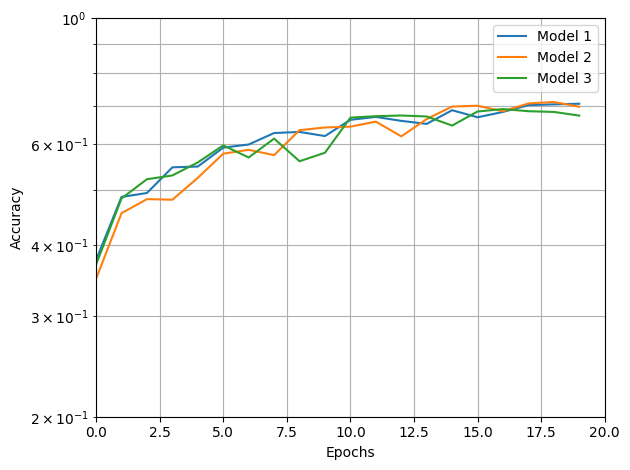

In [12]:
# 3D: APPLY 3 BEST CNN MODELS TO CIFAR10 DATA
if load_existing == False:

   filename = "cifar10_cnn_best_hp"
   if not os.path.exists(filename):
      os.makedirs(filename)

   best_hp_sets = tuner_cnn.get_best_hyperparameters(num_trials=3)

   for ind,best_hps in enumerate(best_hp_sets):
      model_best_cf = build_model_cnn(best_hps,input_shape=[cf_x_train.shape[1],cf_x_train.shape[2],cf_x_train.shape[3]])
      print(cf_x_train.shape)
      model_best_cf.build()
      print(model_best_cf.summary())
      history = model_best_cf.fit(cf_x_train, cf_y_train_cat, epochs=20, validation_split=0.1, callbacks=callbacks)
      # np.save(f'{filename}/{filename}_{ind+1}.npy', history.history)  # Save the history as a NumPy array
      plt.plot(history.history['val_accuracy'], label=f'Model {ind+1}')

   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   plt.yscale('log')
   plt.grid(True, which='both')
   plt.ylim([0.2,1])
   plt.xlim([0,20])
   plt.legend()
   plt.tight_layout()
   plt.savefig('./figures/CIFAR10_CNN.pdf')
   plt.show()

In [13]:
# 3E: COMPARE RESULTS WITH CIFAR10 DATA

for ind,best_trial in enumerate(tuner_cnn.oracle.get_best_trials(3)):
  cf_hist = np.load(f"cifar10_cnn_best_hp/cifar10_cnn_best_hp_{ind+1}.npy",allow_pickle=True).item()
  best_cf_val_acc_ind = np.argmax(cf_hist["val_accuracy"])
  print(f"Best trial {ind+1}")
  print(f'fashion_mnist accuracy: {best_trial.metrics.get_best_value("accuracy"):.3f}, fashion_mnist val_accuracy:{best_trial.metrics.get_best_value("val_accuracy"):.3f}')
  print(f'cifar10 accuracy: {cf_hist["accuracy"][best_cf_val_acc_ind]:.3f}, cifar10 val_accuracy:{cf_hist["val_accuracy"][best_cf_val_acc_ind]:.3f}\n')

Best trial 1
fashion_mnist accuracy: 0.931, fashion_mnist val_accuracy:0.919
cifar10 accuracy: 0.704, cifar10 val_accuracy:0.698

Best trial 2
fashion_mnist accuracy: 0.938, fashion_mnist val_accuracy:0.919
cifar10 accuracy: 0.717, cifar10 val_accuracy:0.699

Best trial 3
fashion_mnist accuracy: 0.927, fashion_mnist val_accuracy:0.919
cifar10 accuracy: 0.724, cifar10 val_accuracy:0.707



313/313 [==============================] - 1s 2ms/step


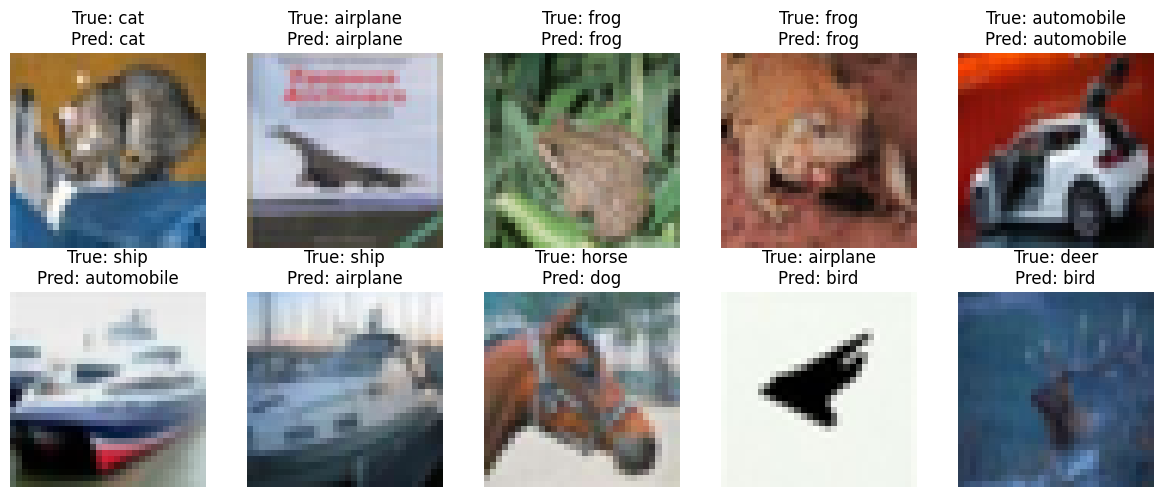

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(correct_images, incorrect_images, correct_labels, incorrect_labels, pred_labels_correct, pred_labels_incorrect, class_names):
    """Plot images with their class names, 5 correct on top and 5 incorrect on bottom."""
    plt.figure(figsize=(12, 5))  # Increased figure size for two rows

    # Plot the first 5 correctly classified images
    for i in range(5):
        plt.subplot(2, 5, i+1)  # Changed to 2 rows and 5 columns
        plt.imshow(correct_images[i], interpolation='none')
        true_class = class_names[correct_labels[i]]
        pred_class = class_names[pred_labels_correct[i]]
        plt.title(f"True: {true_class}\nPred: {pred_class}")
        plt.axis('off')

    # Plot the first 5 incorrectly classified images
    for i in range(5):
        plt.subplot(2, 5, i+6)  # Positions 6-10 for the bottom row
        plt.imshow(incorrect_images[i], interpolation='none')
        true_class = class_names[incorrect_labels[i]]
        pred_class = class_names[pred_labels_incorrect[i]]
        plt.title(f"True: {true_class}\nPred: {pred_class}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./figures/CNN_transfer_CIFAR.pdf')
    plt.show()

# Load your dataset
test_images, test_labels_cat = cf_x_test, cf_y_test_cat

# Get predictions
predictions = model_best_cf.predict(test_images)

# Convert predictions to labels
pred_labels = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_labels_cat, axis=1)

# Compare predictions to true labels
correct = pred_labels == test_labels
incorrect = ~correct

# Get images and labels for correct classifications
correct_images = test_images[correct]
correct_labels = test_labels[correct]

# Get images and labels for incorrect classifications
incorrect_images = test_images[incorrect]
incorrect_labels = test_labels[incorrect]

cf_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plot_images(
    correct_images[:5], incorrect_images[:5],
    correct_labels[:5], incorrect_labels[:5],
    pred_labels[correct][:5], pred_labels[incorrect][:5],
    cf_class_names
)



In [37]:
print(np.sum(incorrect))

3425


In [15]:
test_images, test_labels = cf_x_test, cf_y_test_cat
print(test_labels)
# predictions = model_best_cf.predict(test_images)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [1]:
print('hello')

hello
